In [86]:
import xml.etree.ElementTree as et
from pathlib import Path
import shutil
import yaml
from ultralytics import YOLO
from IPython.display import Image

classes = 'helmet','head','person'

def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    w, h = box[2] - box[0], box[3] - box[1]
    x, y = box[0] + w / 2, box[1] + h / 2
    return x * dw, y * dh, w * dw, h * dh

def VOCtoYOLO(file_xml, out_dir):
    tree = et.parse(file_xml)
    root = tree.getroot()
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)
    with open((out_dir / file_xml.stem).with_suffix('.txt'), 'w') as out_file:
        for obj in root.iter("object"):
            cls_name = obj.find("name").text
            if cls_name in classes:
                bndbox = obj.find("bndbox")
                newbox = convert_box((w, h), [int(bndbox.find(crd).text) for crd in ('xmin', 'ymin', 'xmax', 'ymax')])
                out_file.write(" ".join(str(a) for a in (classes.index(cls_name), *newbox)) + '\n')

dir = Path.cwd() / 'datasets/helmet'
path_img = dir / 'images'
(dir / 'train/images').mkdir(exist_ok=True, parents=True)
(dir / 'val/images').mkdir(exist_ok=True, parents=True)
(dir / 'test/images').mkdir(exist_ok=True, parents=True)
(dir / 'train/labels').mkdir(exist_ok=True, parents=True)
(dir / 'val/labels').mkdir(exist_ok=True, parents=True)
(dir / 'test/labels').mkdir(exist_ok=True, parents=True)

for i, ann in enumerate((dir / 'annotations').iterdir()): # 70% / 20% / 10% split
    if i < 3500:
        VOCtoYOLO(ann, dir / 'train/labels')
        shutil.copy((path_img / ann.stem).with_suffix('.png'), dir / 'train/images')
    elif i < 4500:
        VOCtoYOLO(ann, dir / 'val/labels')
        shutil.copy((path_img / ann.stem).with_suffix('.png'), dir / 'val/images')
    else:
        VOCtoYOLO(ann, dir / 'test/labels')
        shutil.copy((path_img / ann.stem).with_suffix('.png'), dir / 'test/images')

config = {
   "train": str(dir / 'train/images'),
   "val": str(dir / 'val/images'),
   "test": str(dir / 'test/images'),
   "nc": len(classes),
   "names": [a for a in classes]
}
with open(dir / "data.yaml", "w") as file:
    yaml.dump(config, file)

print("Train images: {0:9d}\nValidation images: {1}\nTest images: {2:10d}".format(len(list((dir / 'train/images').glob('*'))), 
      len(list((dir / 'val/images').glob('*'))), len(list((dir / 'test/images').glob('*')))))

Train images:      3500
Validation images: 1000
Test images:        500


In [3]:
model = YOLO("yolov8s.pt")
results = model.train(data=dir / "data.yaml", epochs=20, device=0) #amp? imgsz, batch, workers, optimizer, verbose, rect, val, plots

Ultralytics YOLOv8.2.27  Python-3.12.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=d:\Repos\ProtectionDetection\datasets\helmet\data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

d:\Program Files (x86)\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 


train: Scanning D:\Repos\ProtectionDetection\datasets\helmet\train\labels.cache... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:00<?, ?it/s]
val: Scanning D:\Repos\ProtectionDetection\datasets\helmet\val\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.36G      1.487      1.358       1.27         53        640: 100%|██████████| 219/219 [01:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


                   all       1000       5208      0.903      0.528      0.573      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.16G      1.407     0.9755      1.215         68        640: 100%|██████████| 219/219 [01:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]

                   all       1000       5208      0.917      0.524      0.575      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.13G      1.401     0.9401      1.216         53        640: 100%|██████████| 219/219 [00:59<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

                   all       1000       5208      0.911       0.52      0.582      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.13G      1.381     0.9212      1.204         85        640: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]

                   all       1000       5208       0.92      0.516      0.584      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.16G      1.365      0.889        1.2        103        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]

                   all       1000       5208      0.927      0.552      0.594      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.11G       1.33     0.8467      1.179        129        640: 100%|██████████| 219/219 [01:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

                   all       1000       5208       0.93      0.554      0.606      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.12G      1.305     0.8181      1.173         81        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]

                   all       1000       5208      0.937      0.562      0.615      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.15G      1.307     0.7887      1.166         63        640: 100%|██████████| 219/219 [00:59<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]

                   all       1000       5208       0.94      0.559      0.613      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.11G      1.278      0.765      1.163         72        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]

                   all       1000       5208      0.927      0.574      0.616      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.12G      1.264     0.7357       1.15        103        640: 100%|██████████| 219/219 [01:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]

                   all       1000       5208      0.938      0.568      0.619      0.392


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.12G      1.273     0.6885      1.179         71        640: 100%|██████████| 219/219 [01:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]

                   all       1000       5208      0.943      0.576      0.624      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.26G      1.266     0.6631      1.175         62        640: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]

                   all       1000       5208       0.94      0.578      0.623      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.14G      1.249     0.6463      1.167         59        640: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

                   all       1000       5208      0.944      0.577      0.629      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.09G      1.225     0.6181      1.148         41        640: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

                   all       1000       5208      0.942      0.578      0.629      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.15G      1.208     0.6034      1.141         42        640: 100%|██████████| 219/219 [00:58<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]

                   all       1000       5208      0.936      0.587      0.629      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.11G      1.197     0.5848      1.137         42        640: 100%|██████████| 219/219 [00:59<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]

                   all       1000       5208      0.942      0.587      0.631      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.11G      1.184      0.573      1.128         48        640: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]

                   all       1000       5208      0.949      0.582      0.633      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.25G      1.163      0.551      1.114         54        640: 100%|██████████| 219/219 [00:58<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]

                   all       1000       5208      0.939      0.595      0.631      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.12G      1.144     0.5386      1.109         44        640: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]

                   all       1000       5208      0.944      0.586      0.632      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.13G      1.134     0.5259      1.101         60        640: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]

                   all       1000       5208      0.943      0.591      0.634      0.414



20 epochs completed in 0.392 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 22.5MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics YOLOv8.2.27  Python-3.12.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all       1000       5208      0.942      0.593      0.634      0.415
                helmet        919       3903      0.941      0.898      0.957      0.626
                  head        173       1128      0.884      0.879      0.921      0.607
                person         40        177          1          0     0.0226     0.0105
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train16


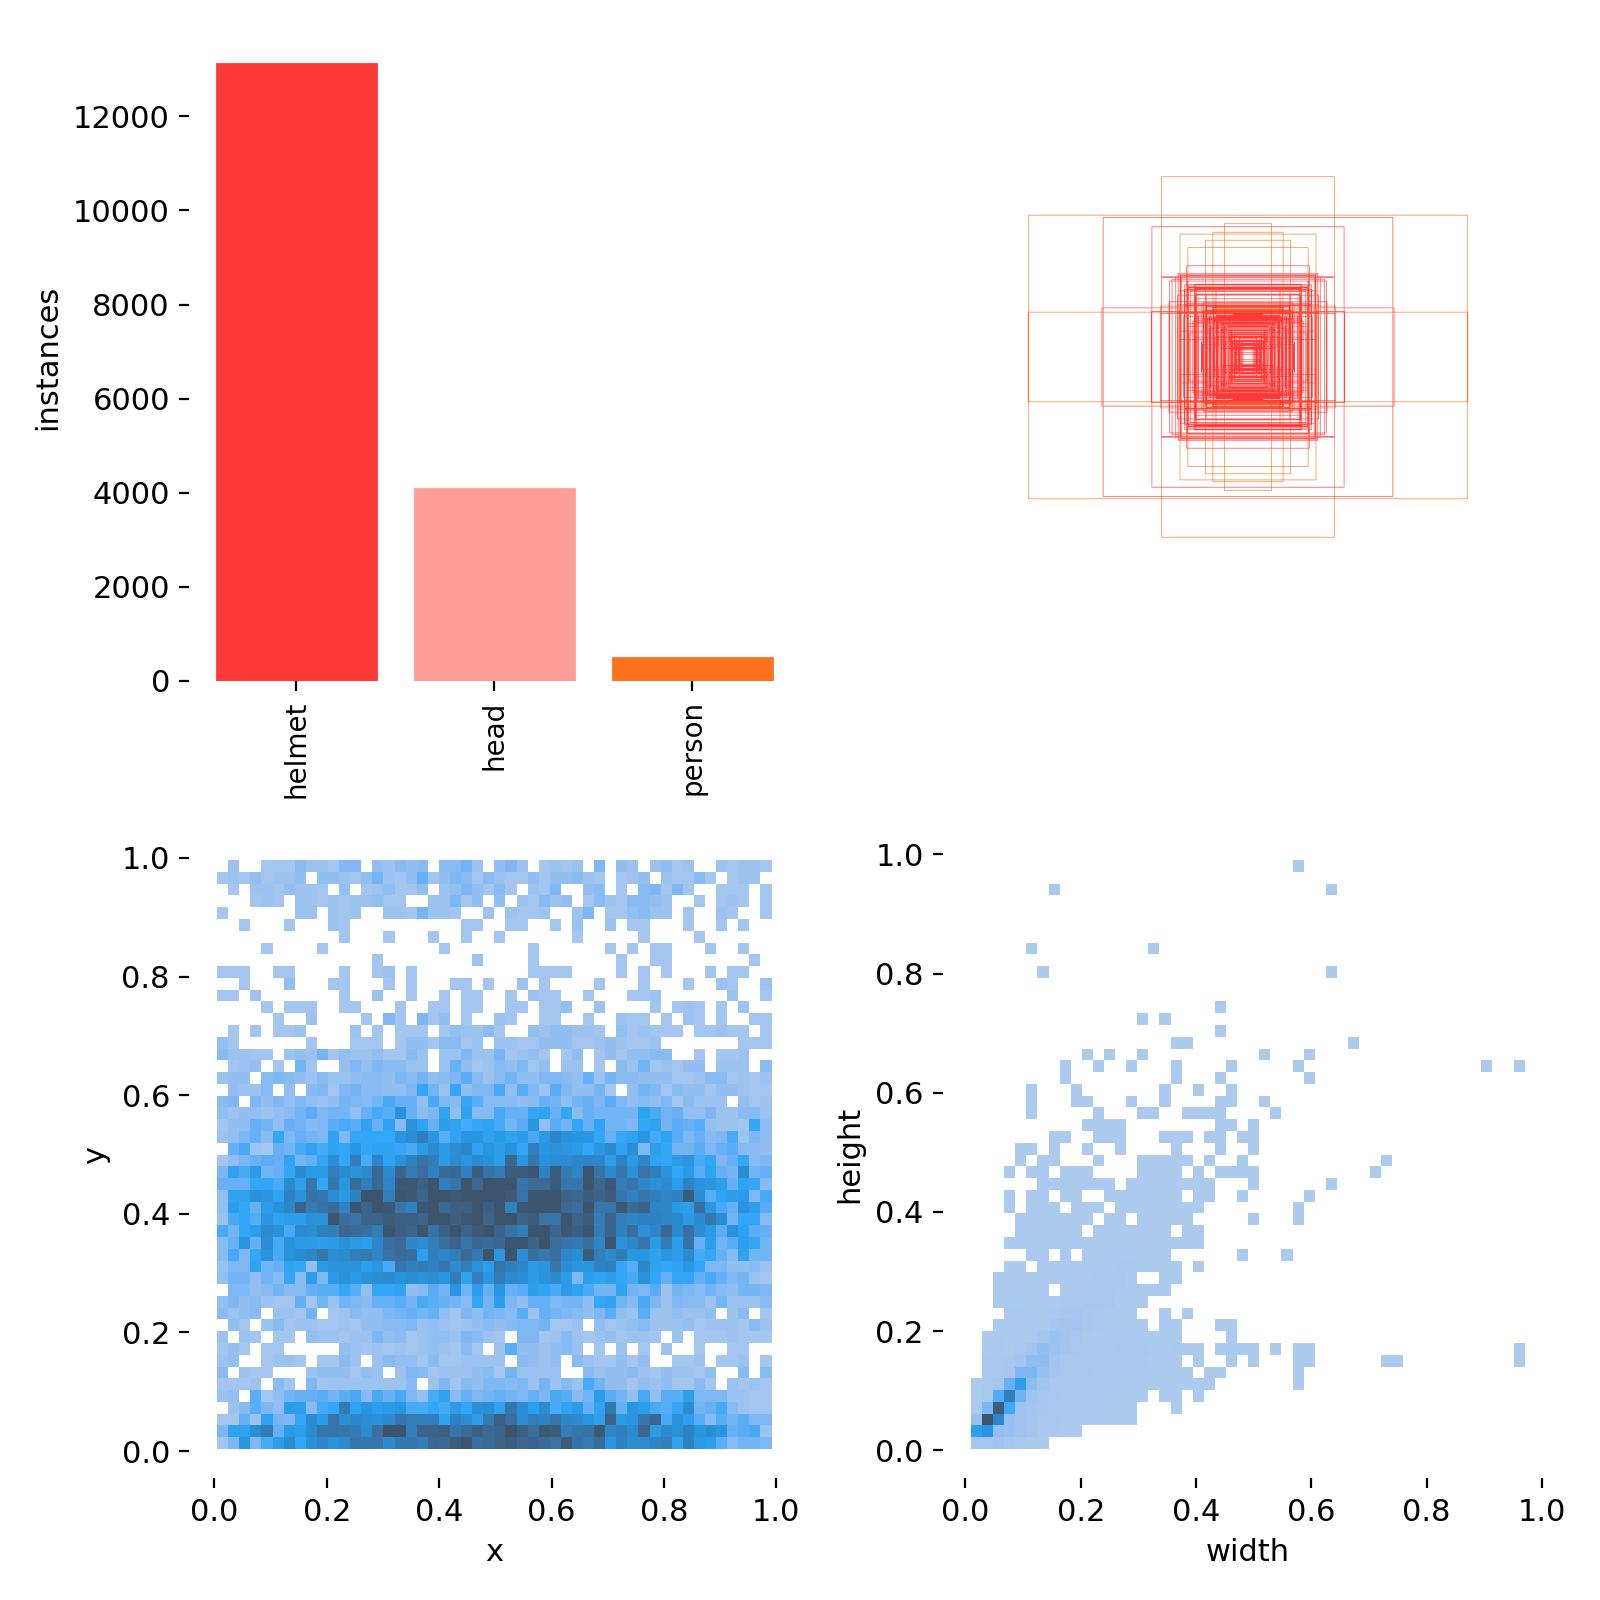

In [18]:
Image(filename=Path.cwd() / 'runs/detect/train16/labels.jpg', width=800)

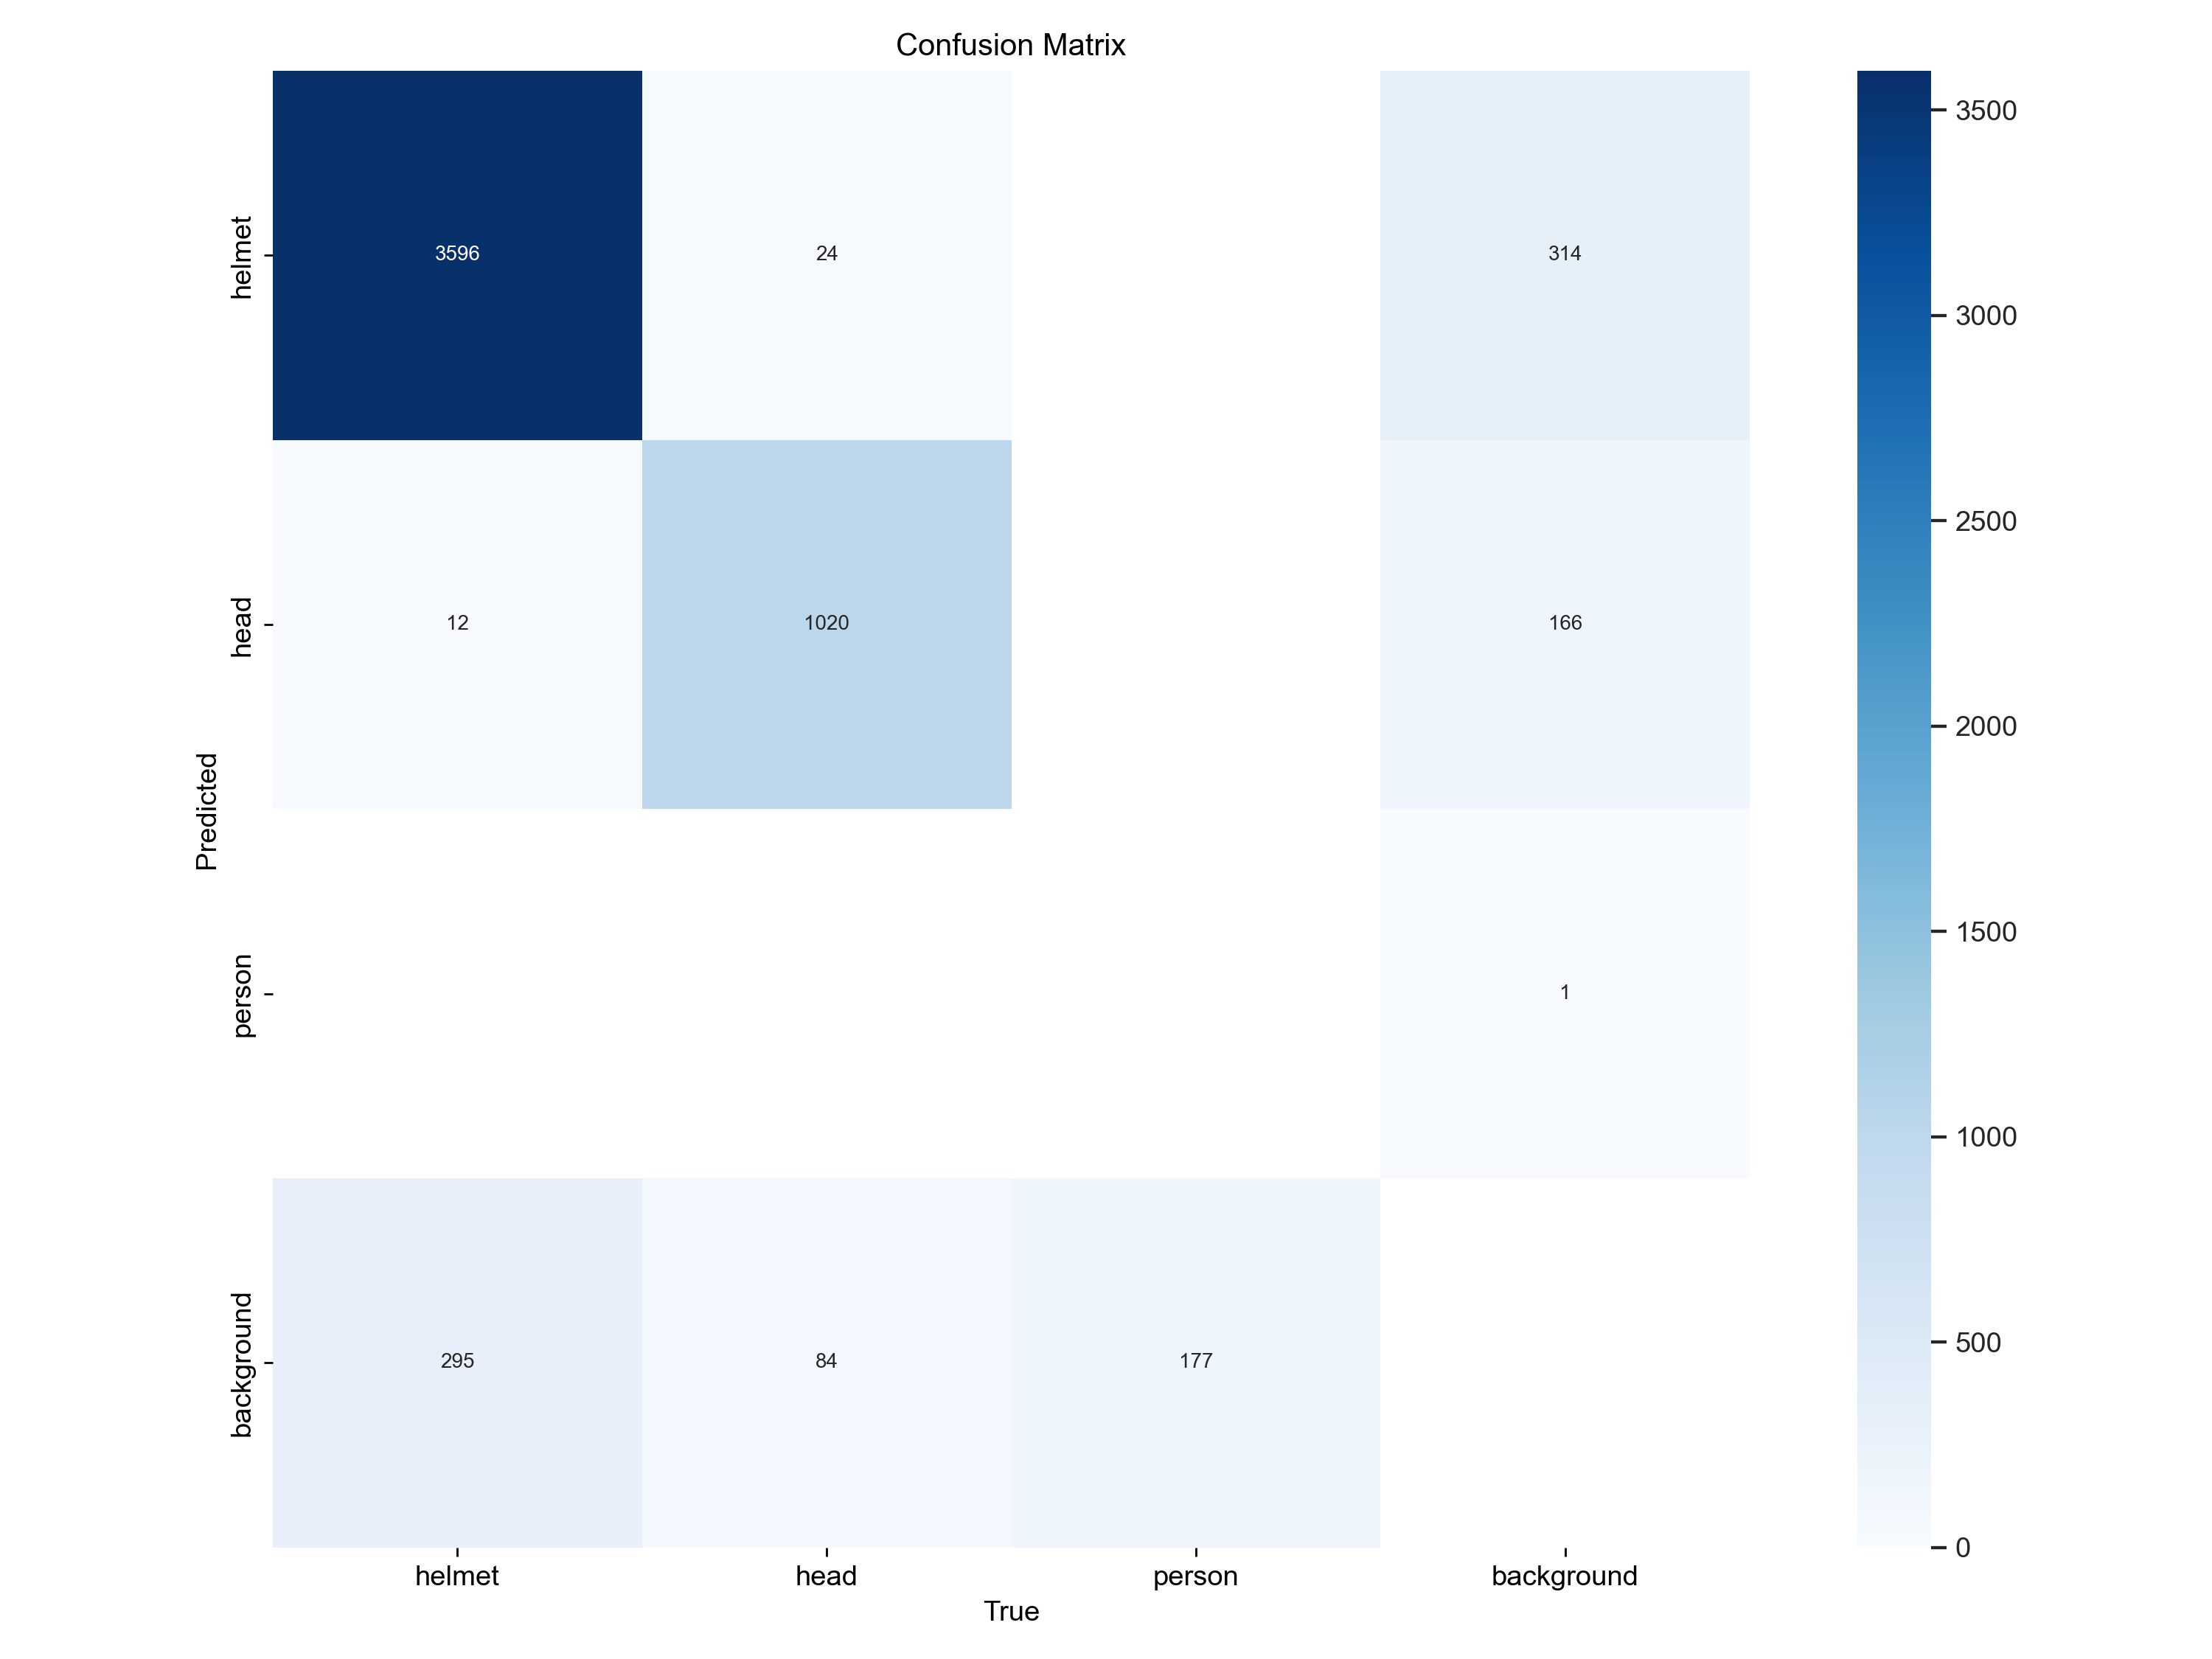

In [16]:
Image(filename=Path.cwd() / 'runs/detect/train16/confusion_matrix.png', width=800)

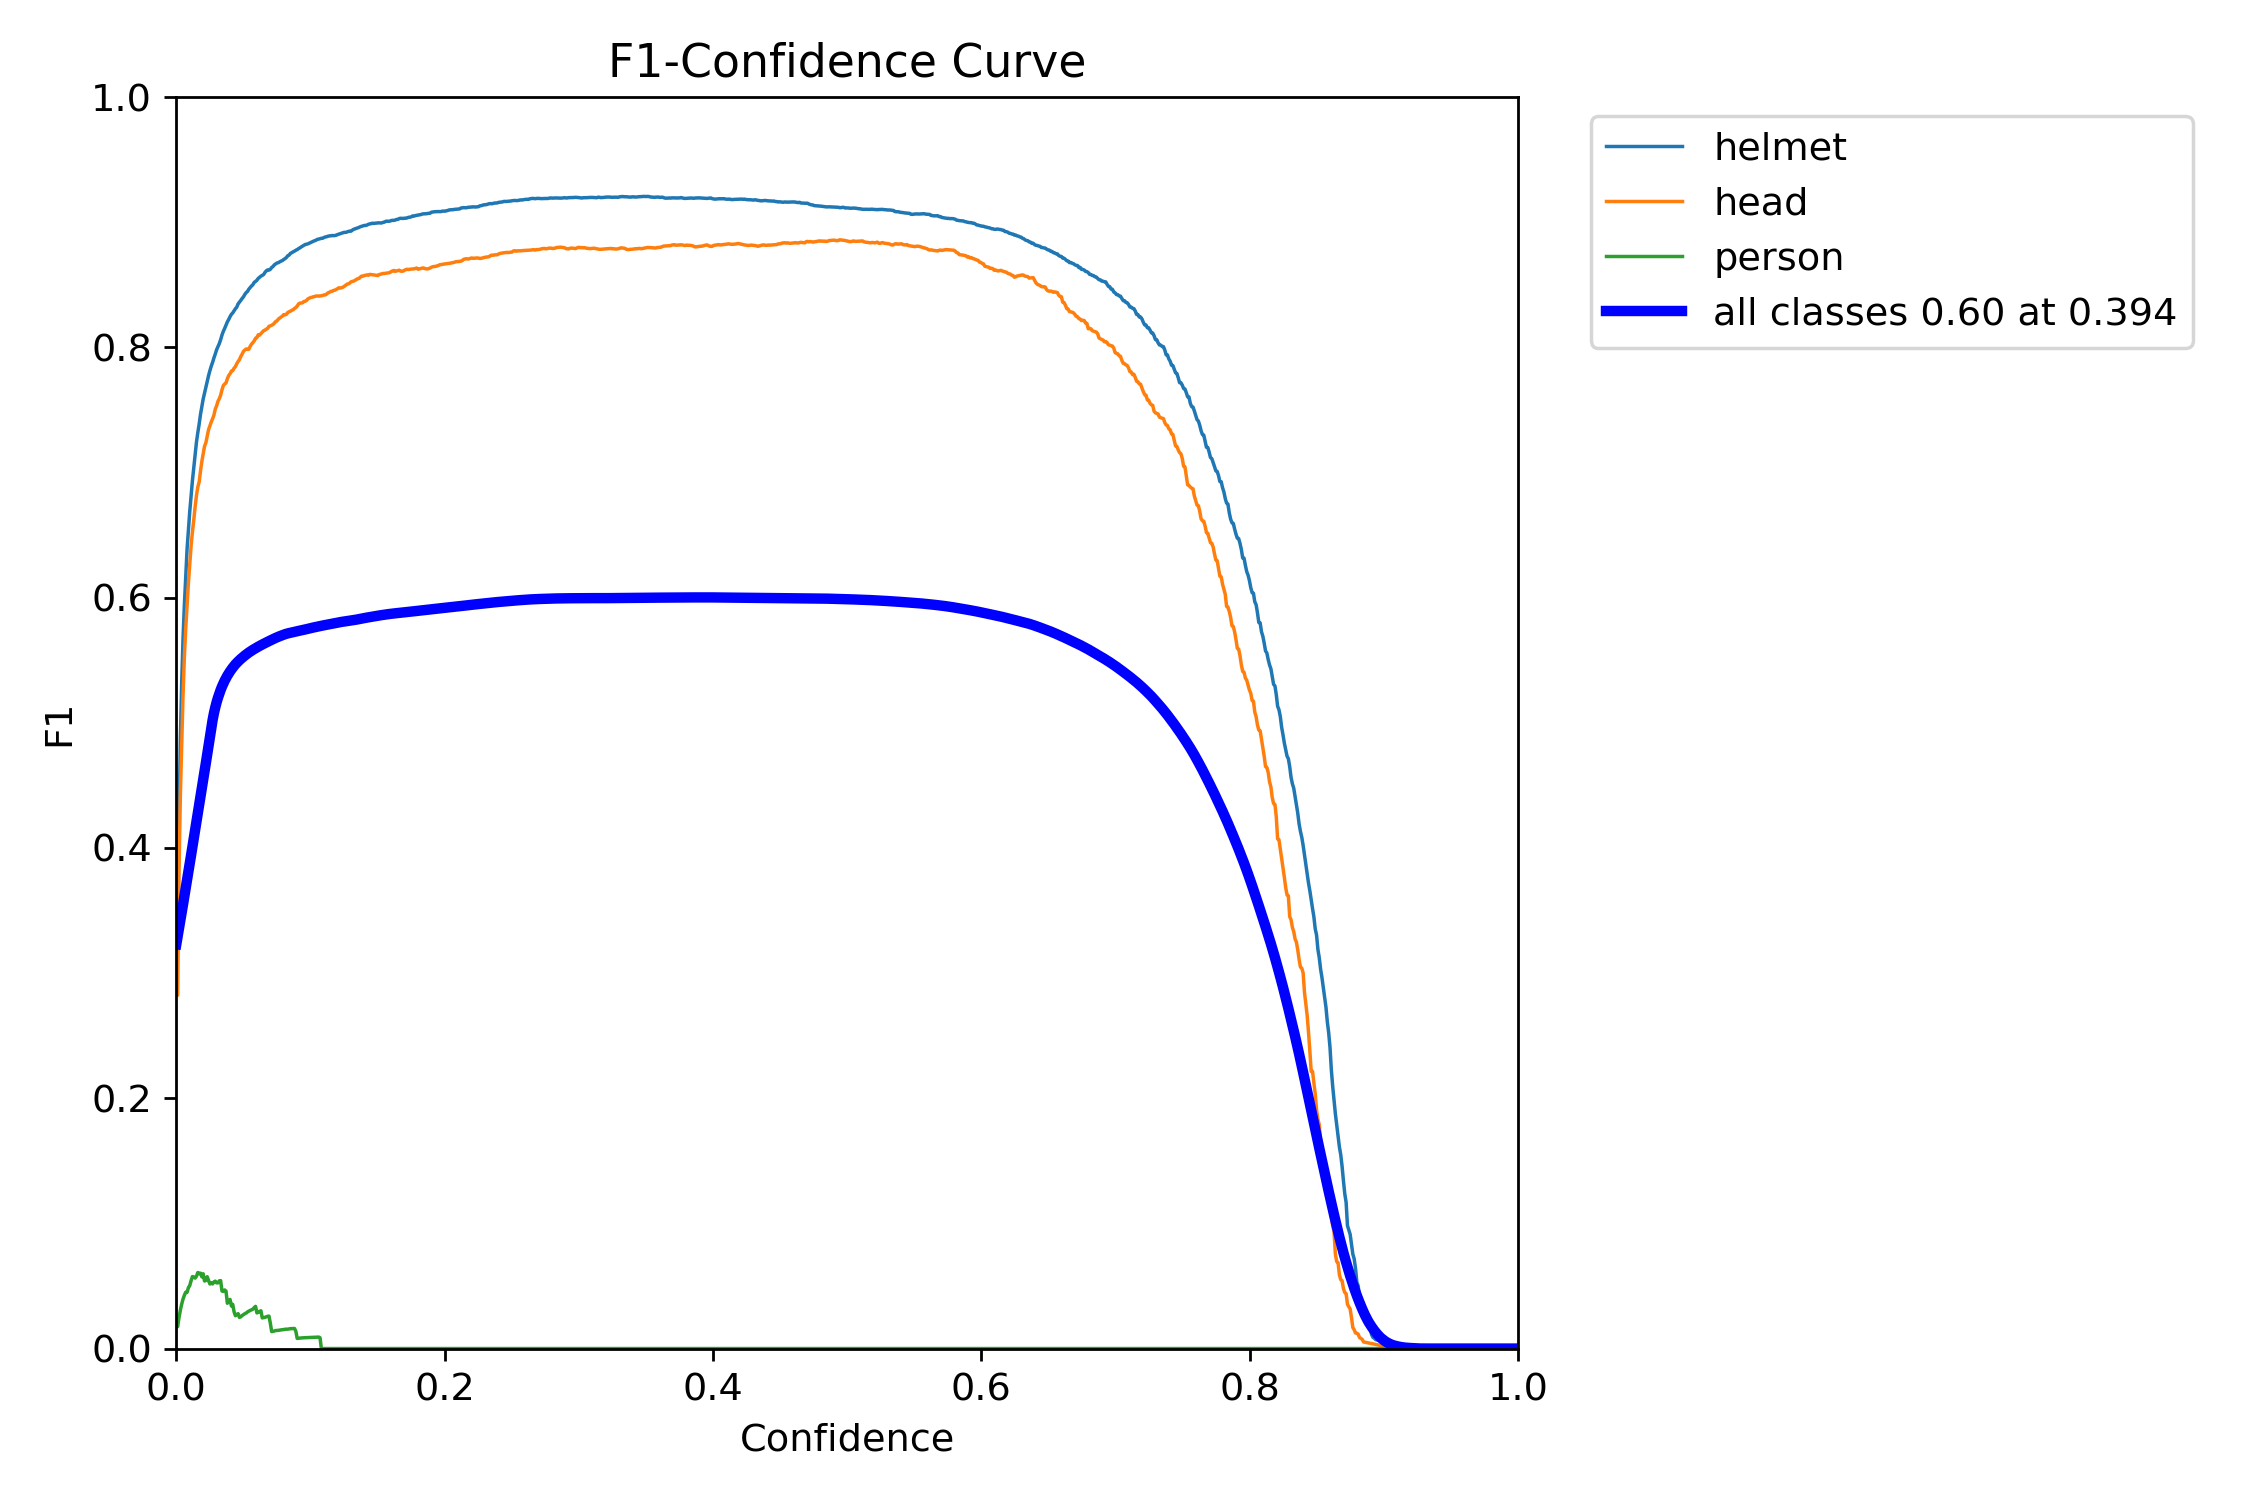

In [8]:
Image(filename=Path.cwd() / 'runs/detect/train16/F1_curve.png', width=1000)

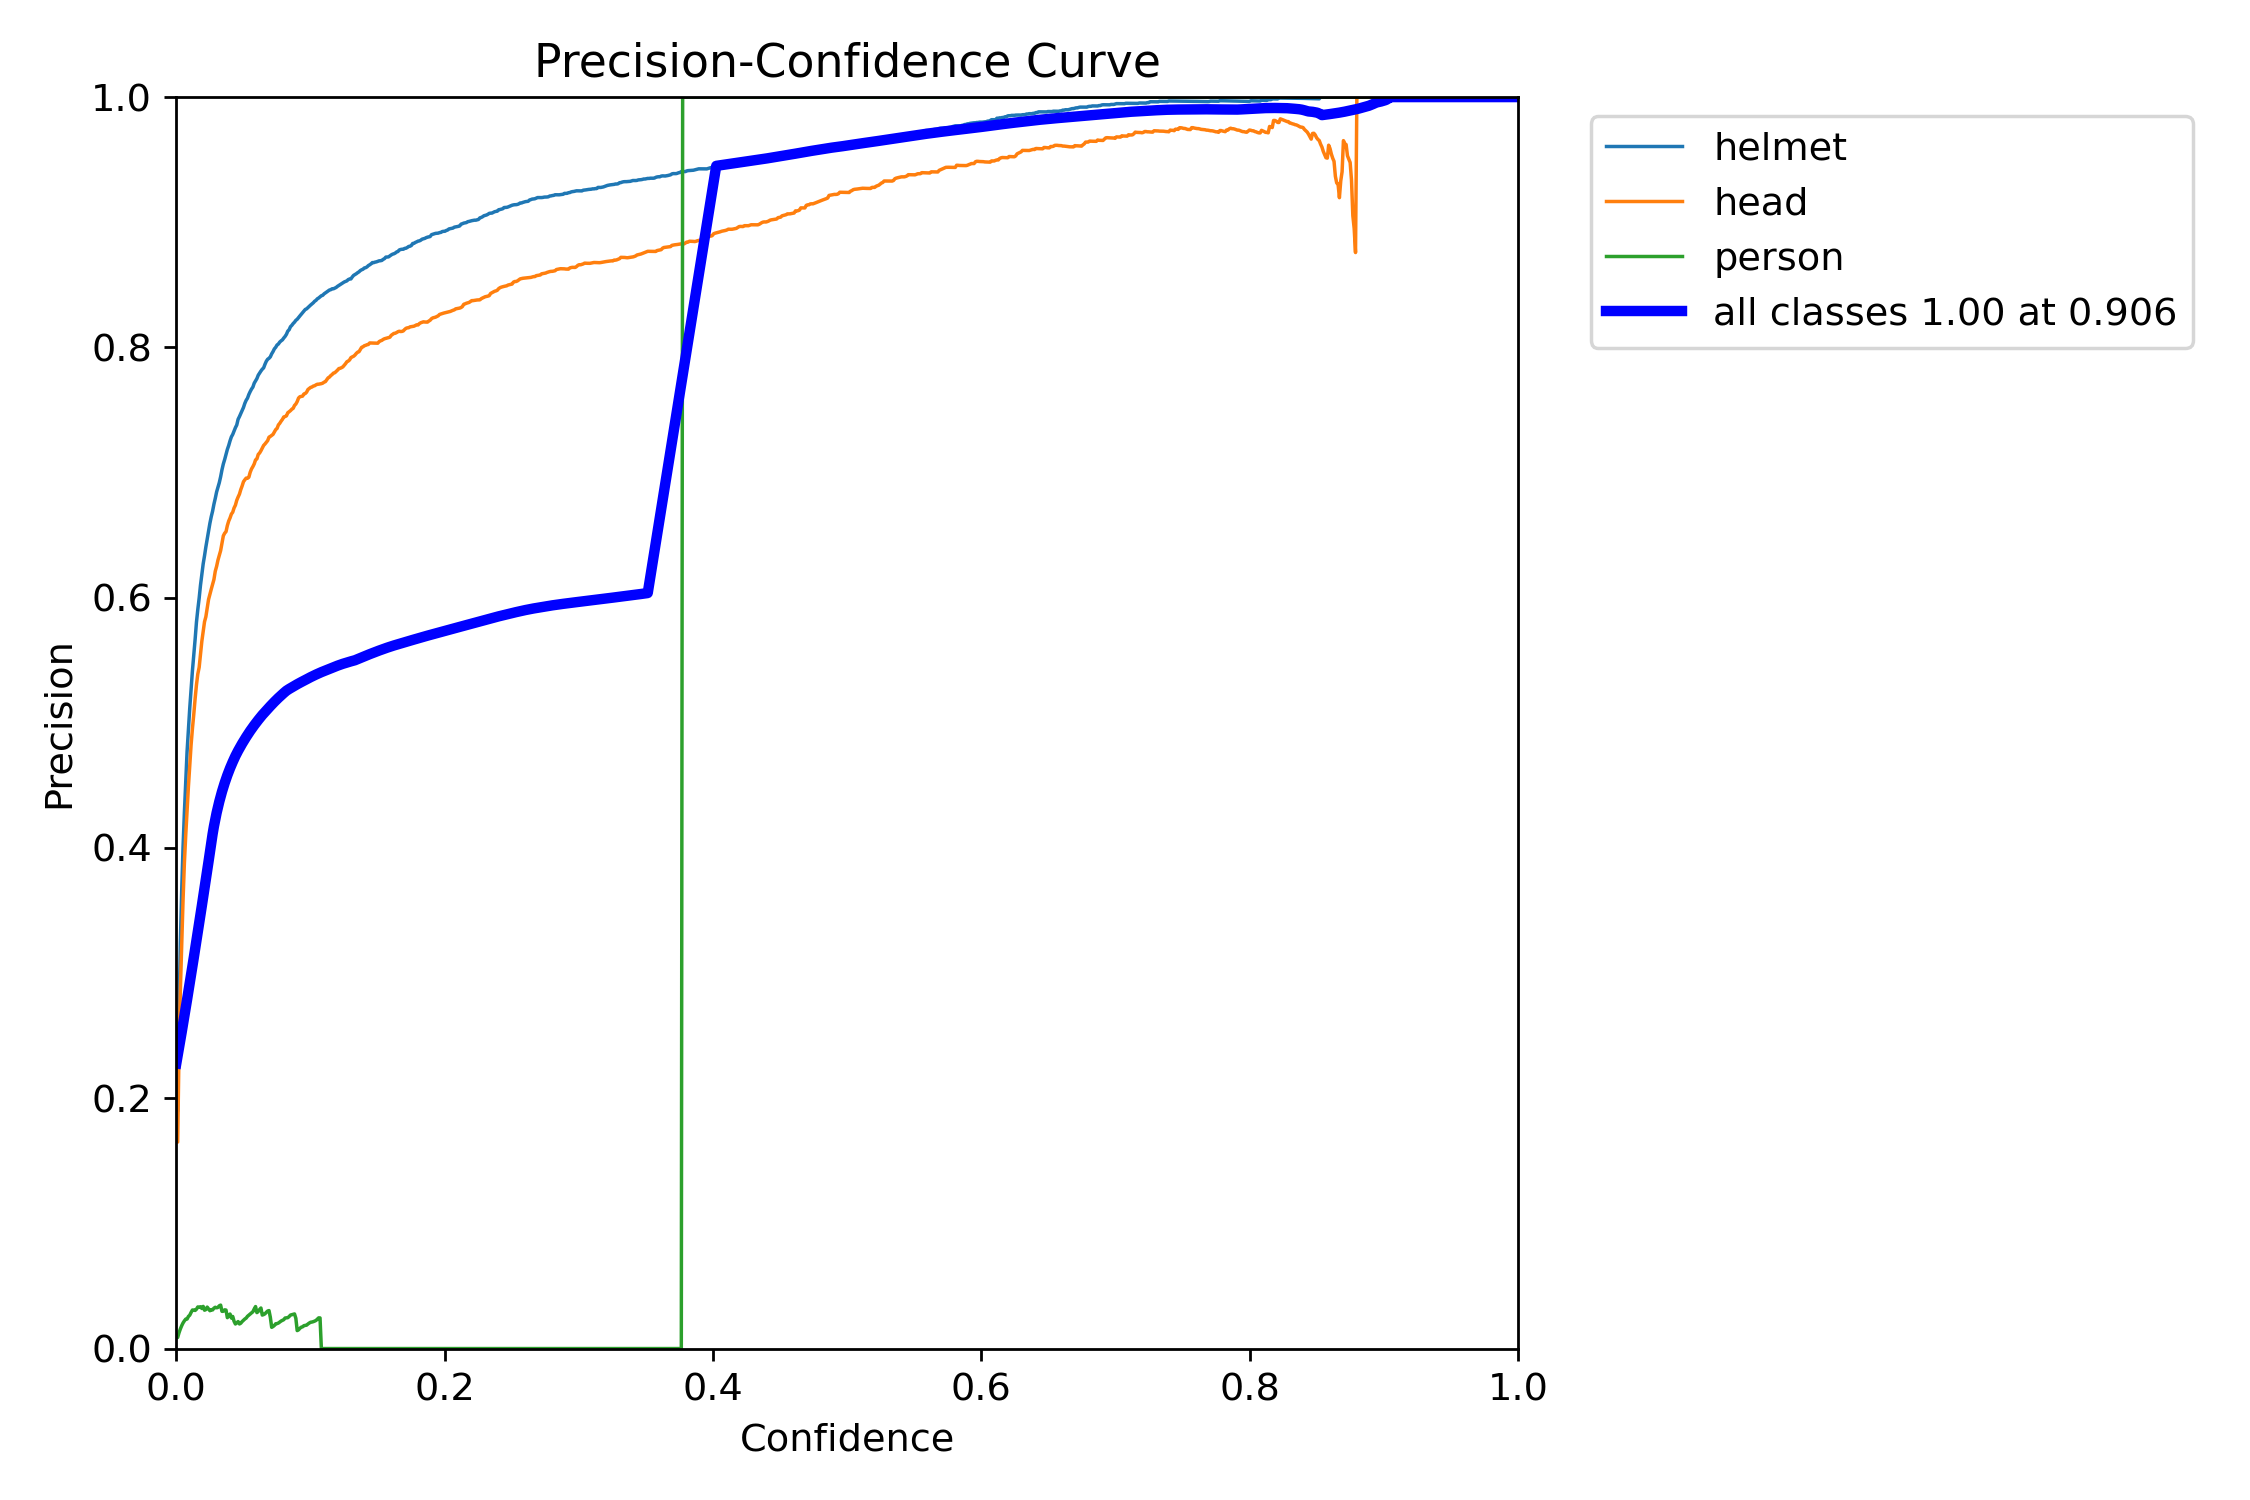

In [21]:
Image(filename=Path.cwd() / 'runs/detect/train16/P_curve.png', width=1000)

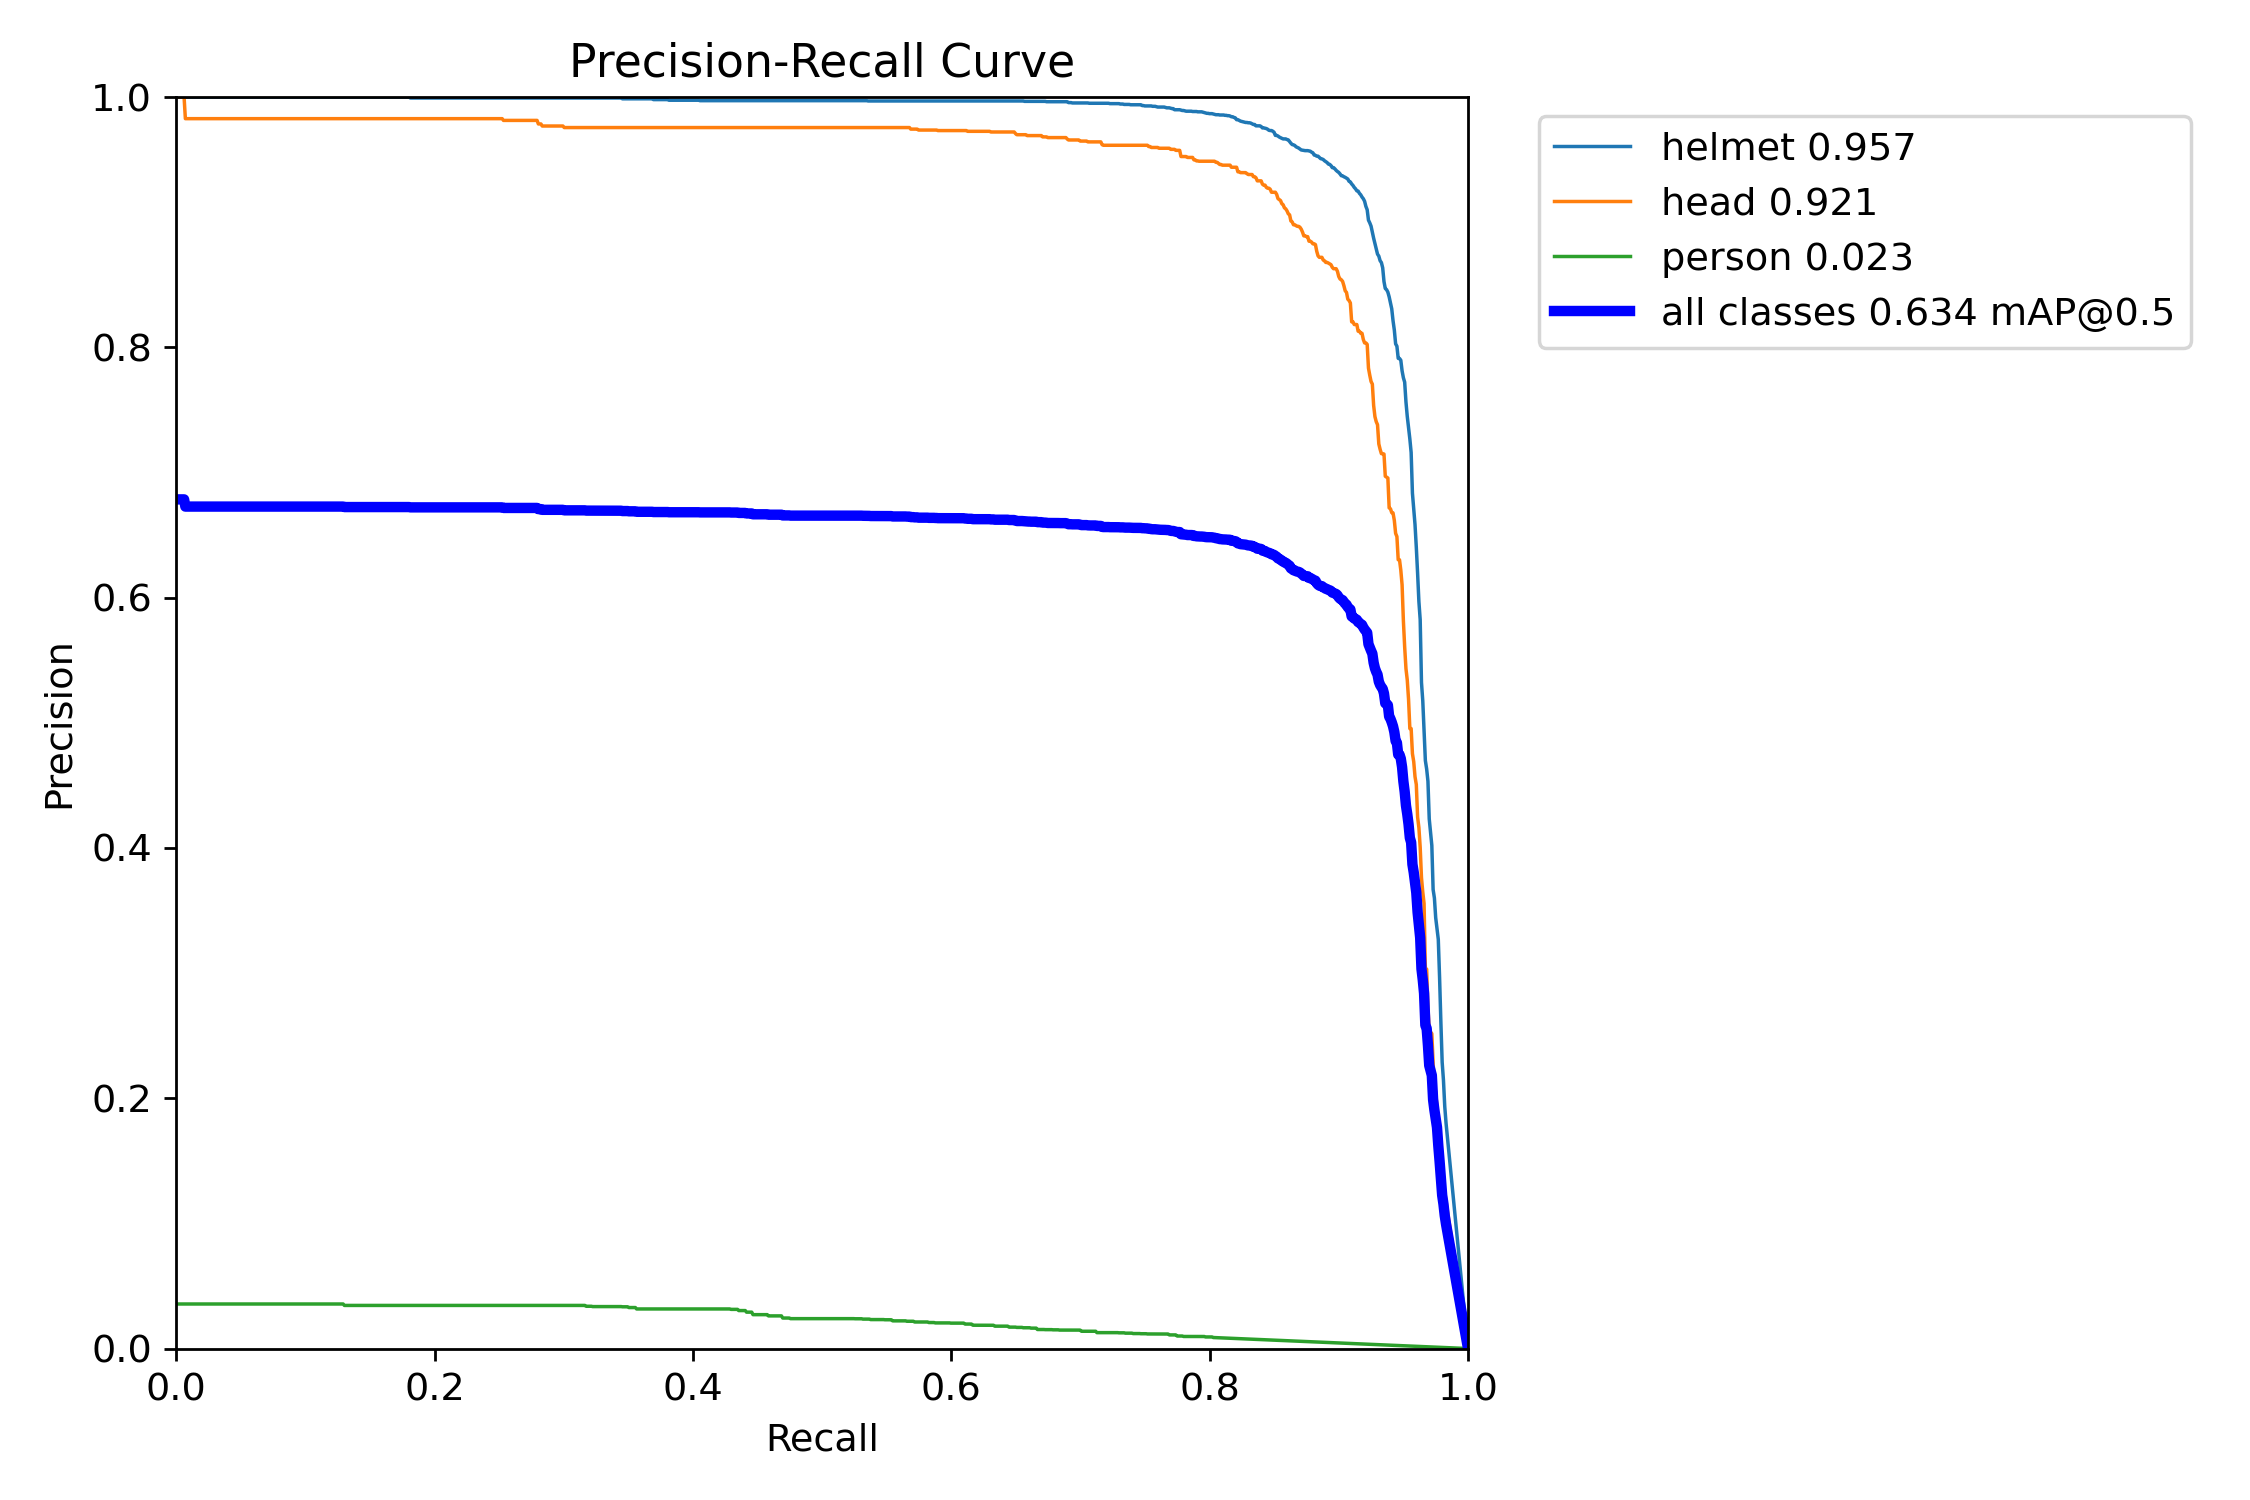

In [22]:
Image(filename=Path.cwd() / 'runs/detect/train16/PR_curve.png', width=1000)

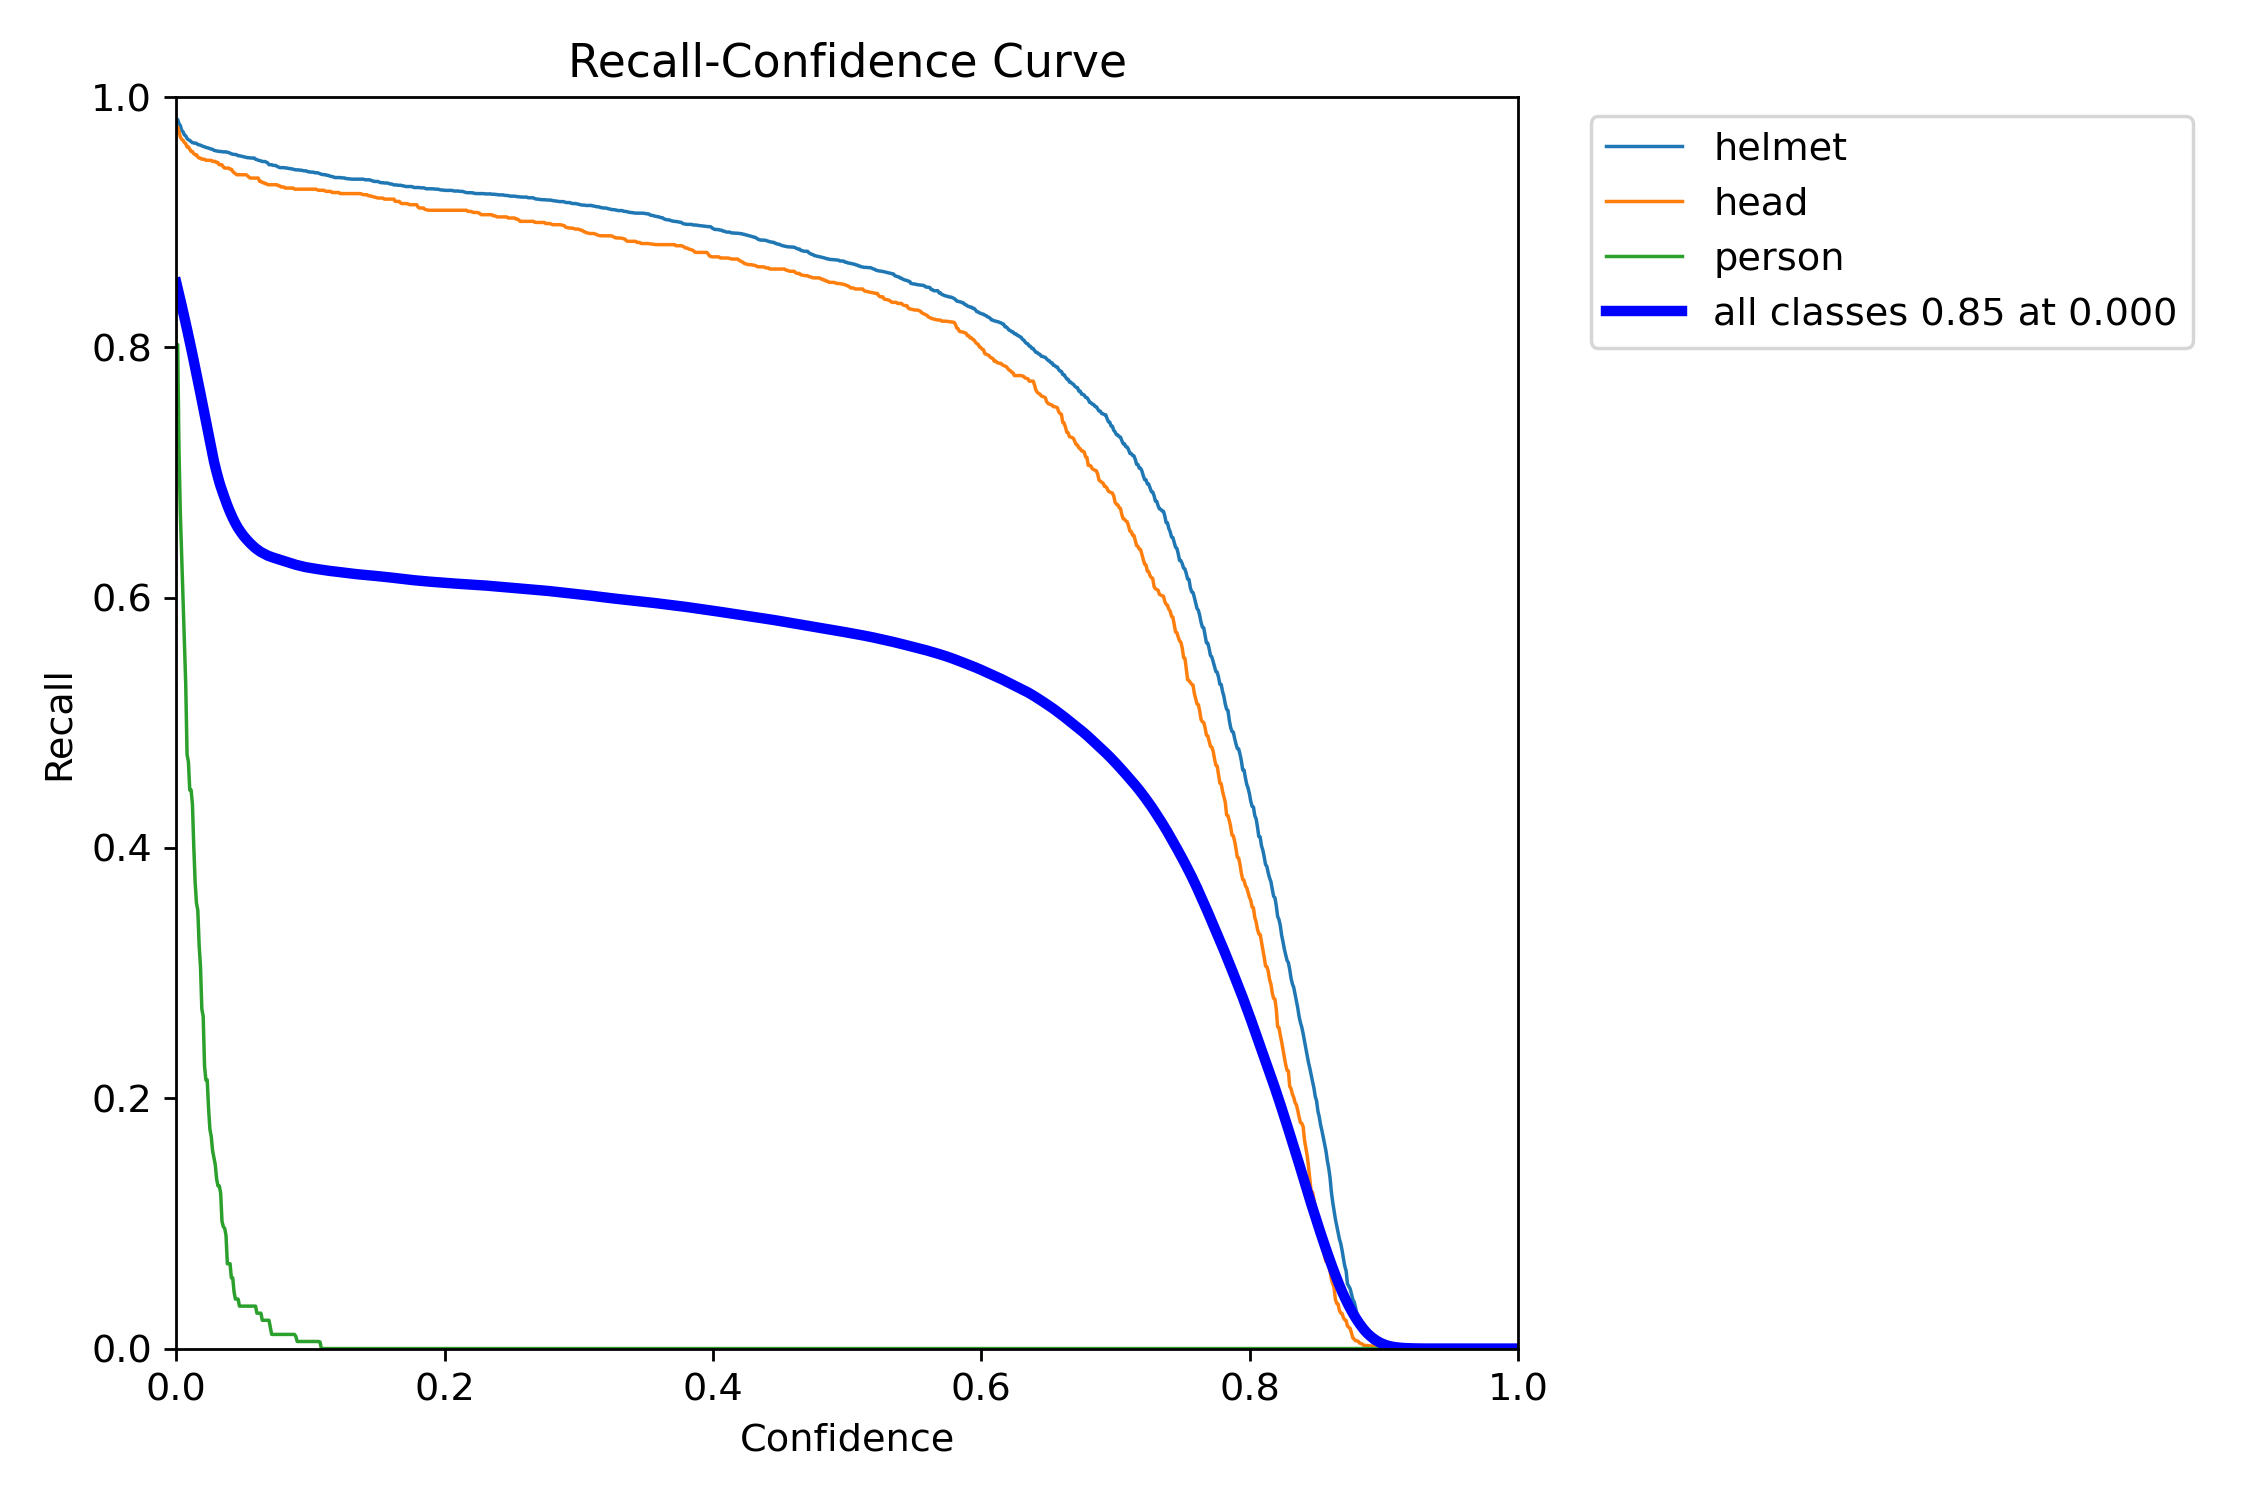

In [23]:
Image(filename=Path.cwd() / 'runs/detect/train16/R_curve.png', width=1000)

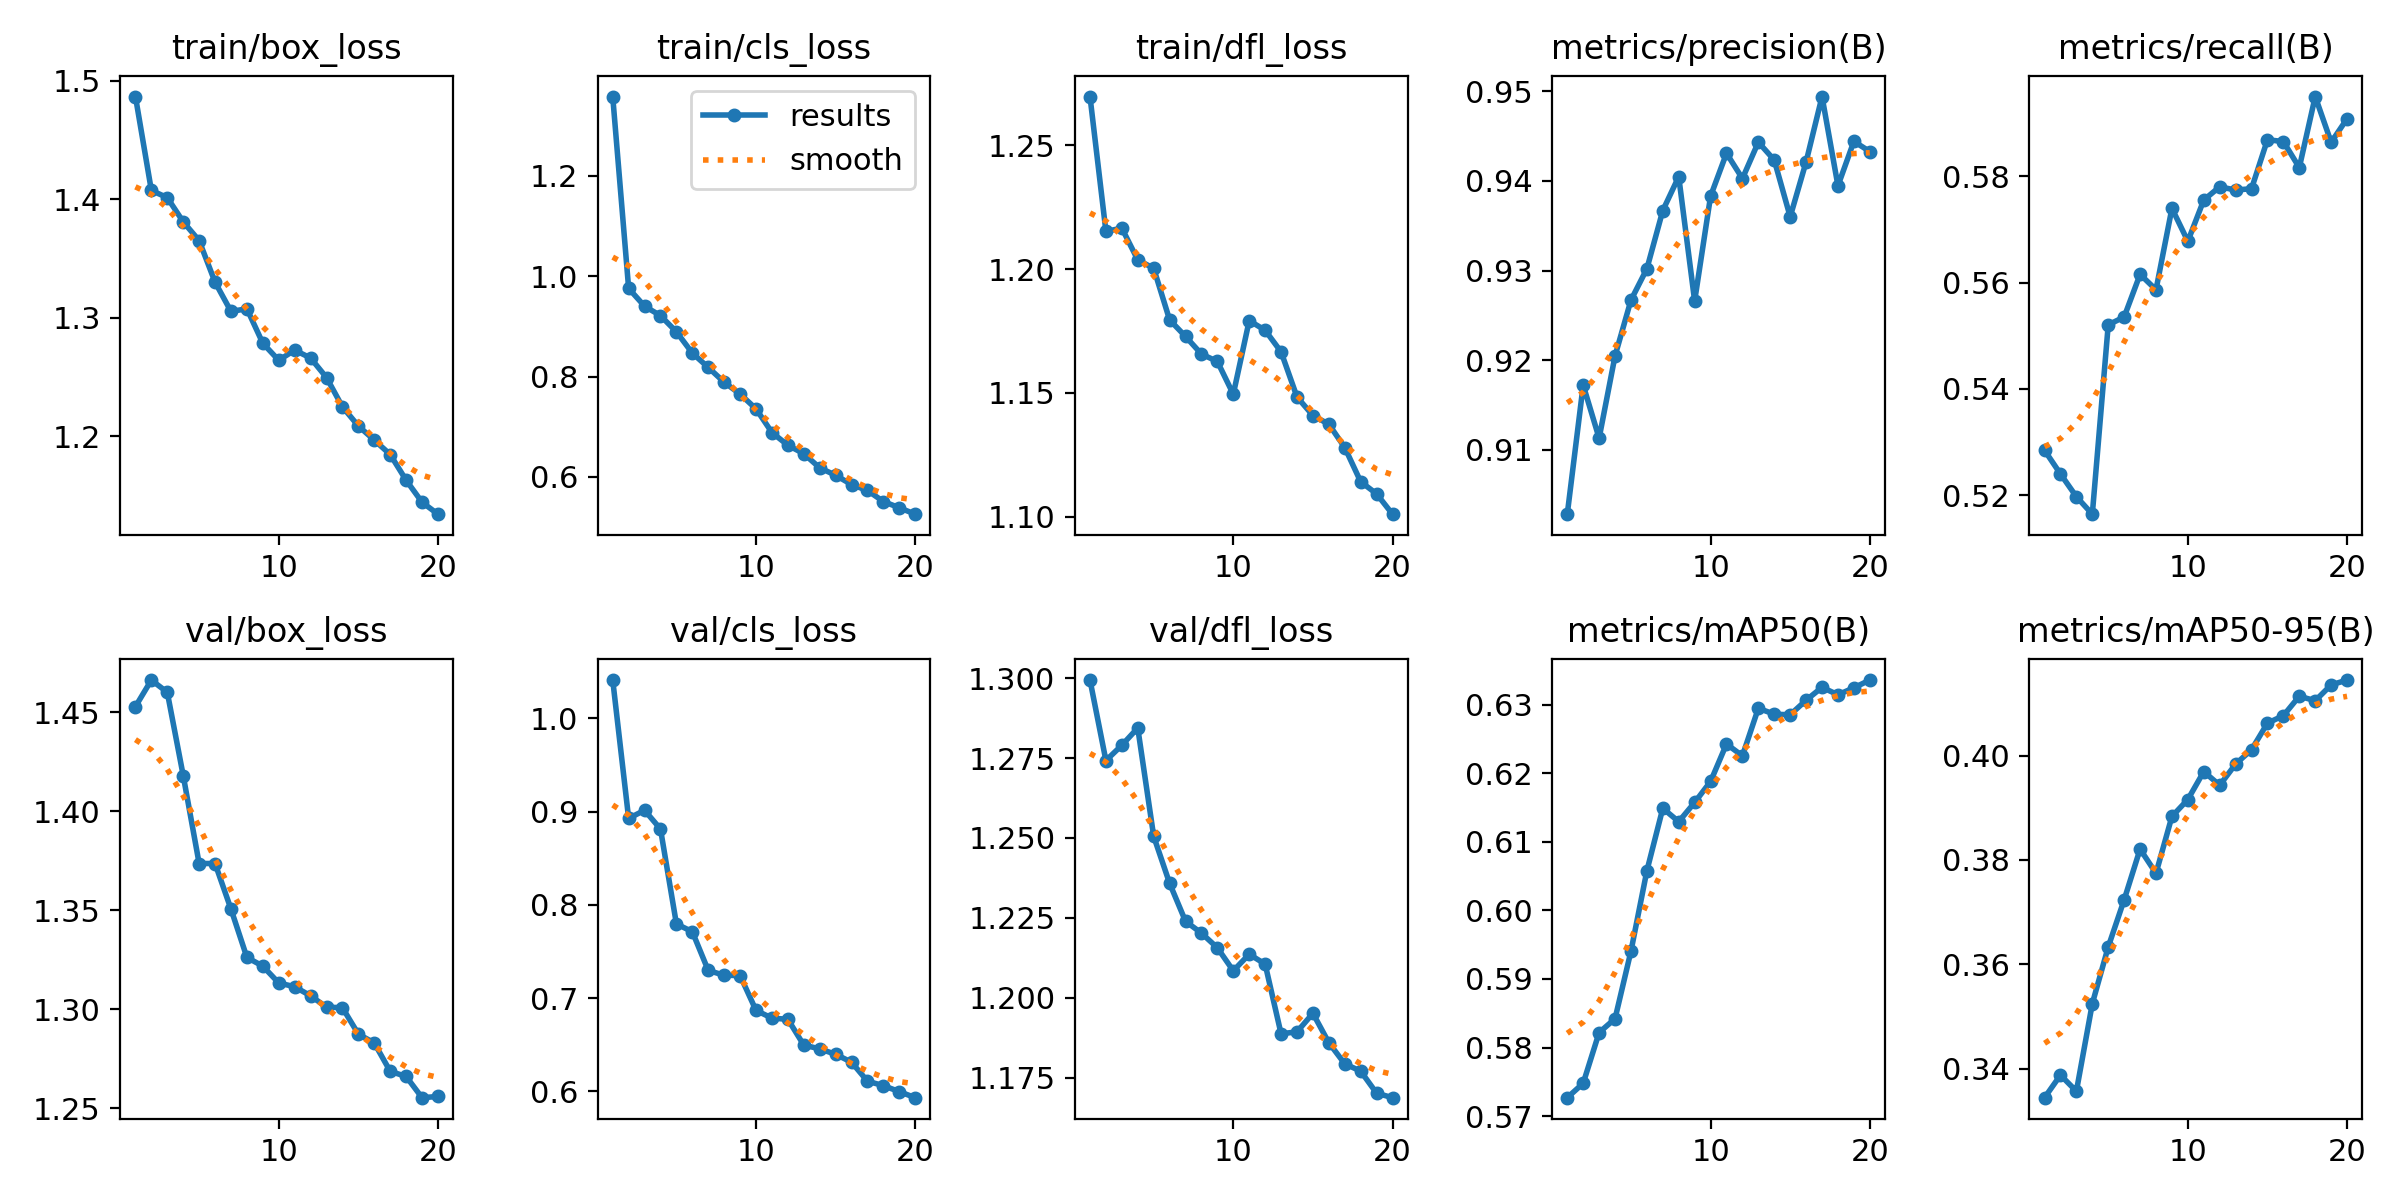

In [25]:
Image(filename=Path.cwd() / 'runs/detect/train16/results.png', width=1200)

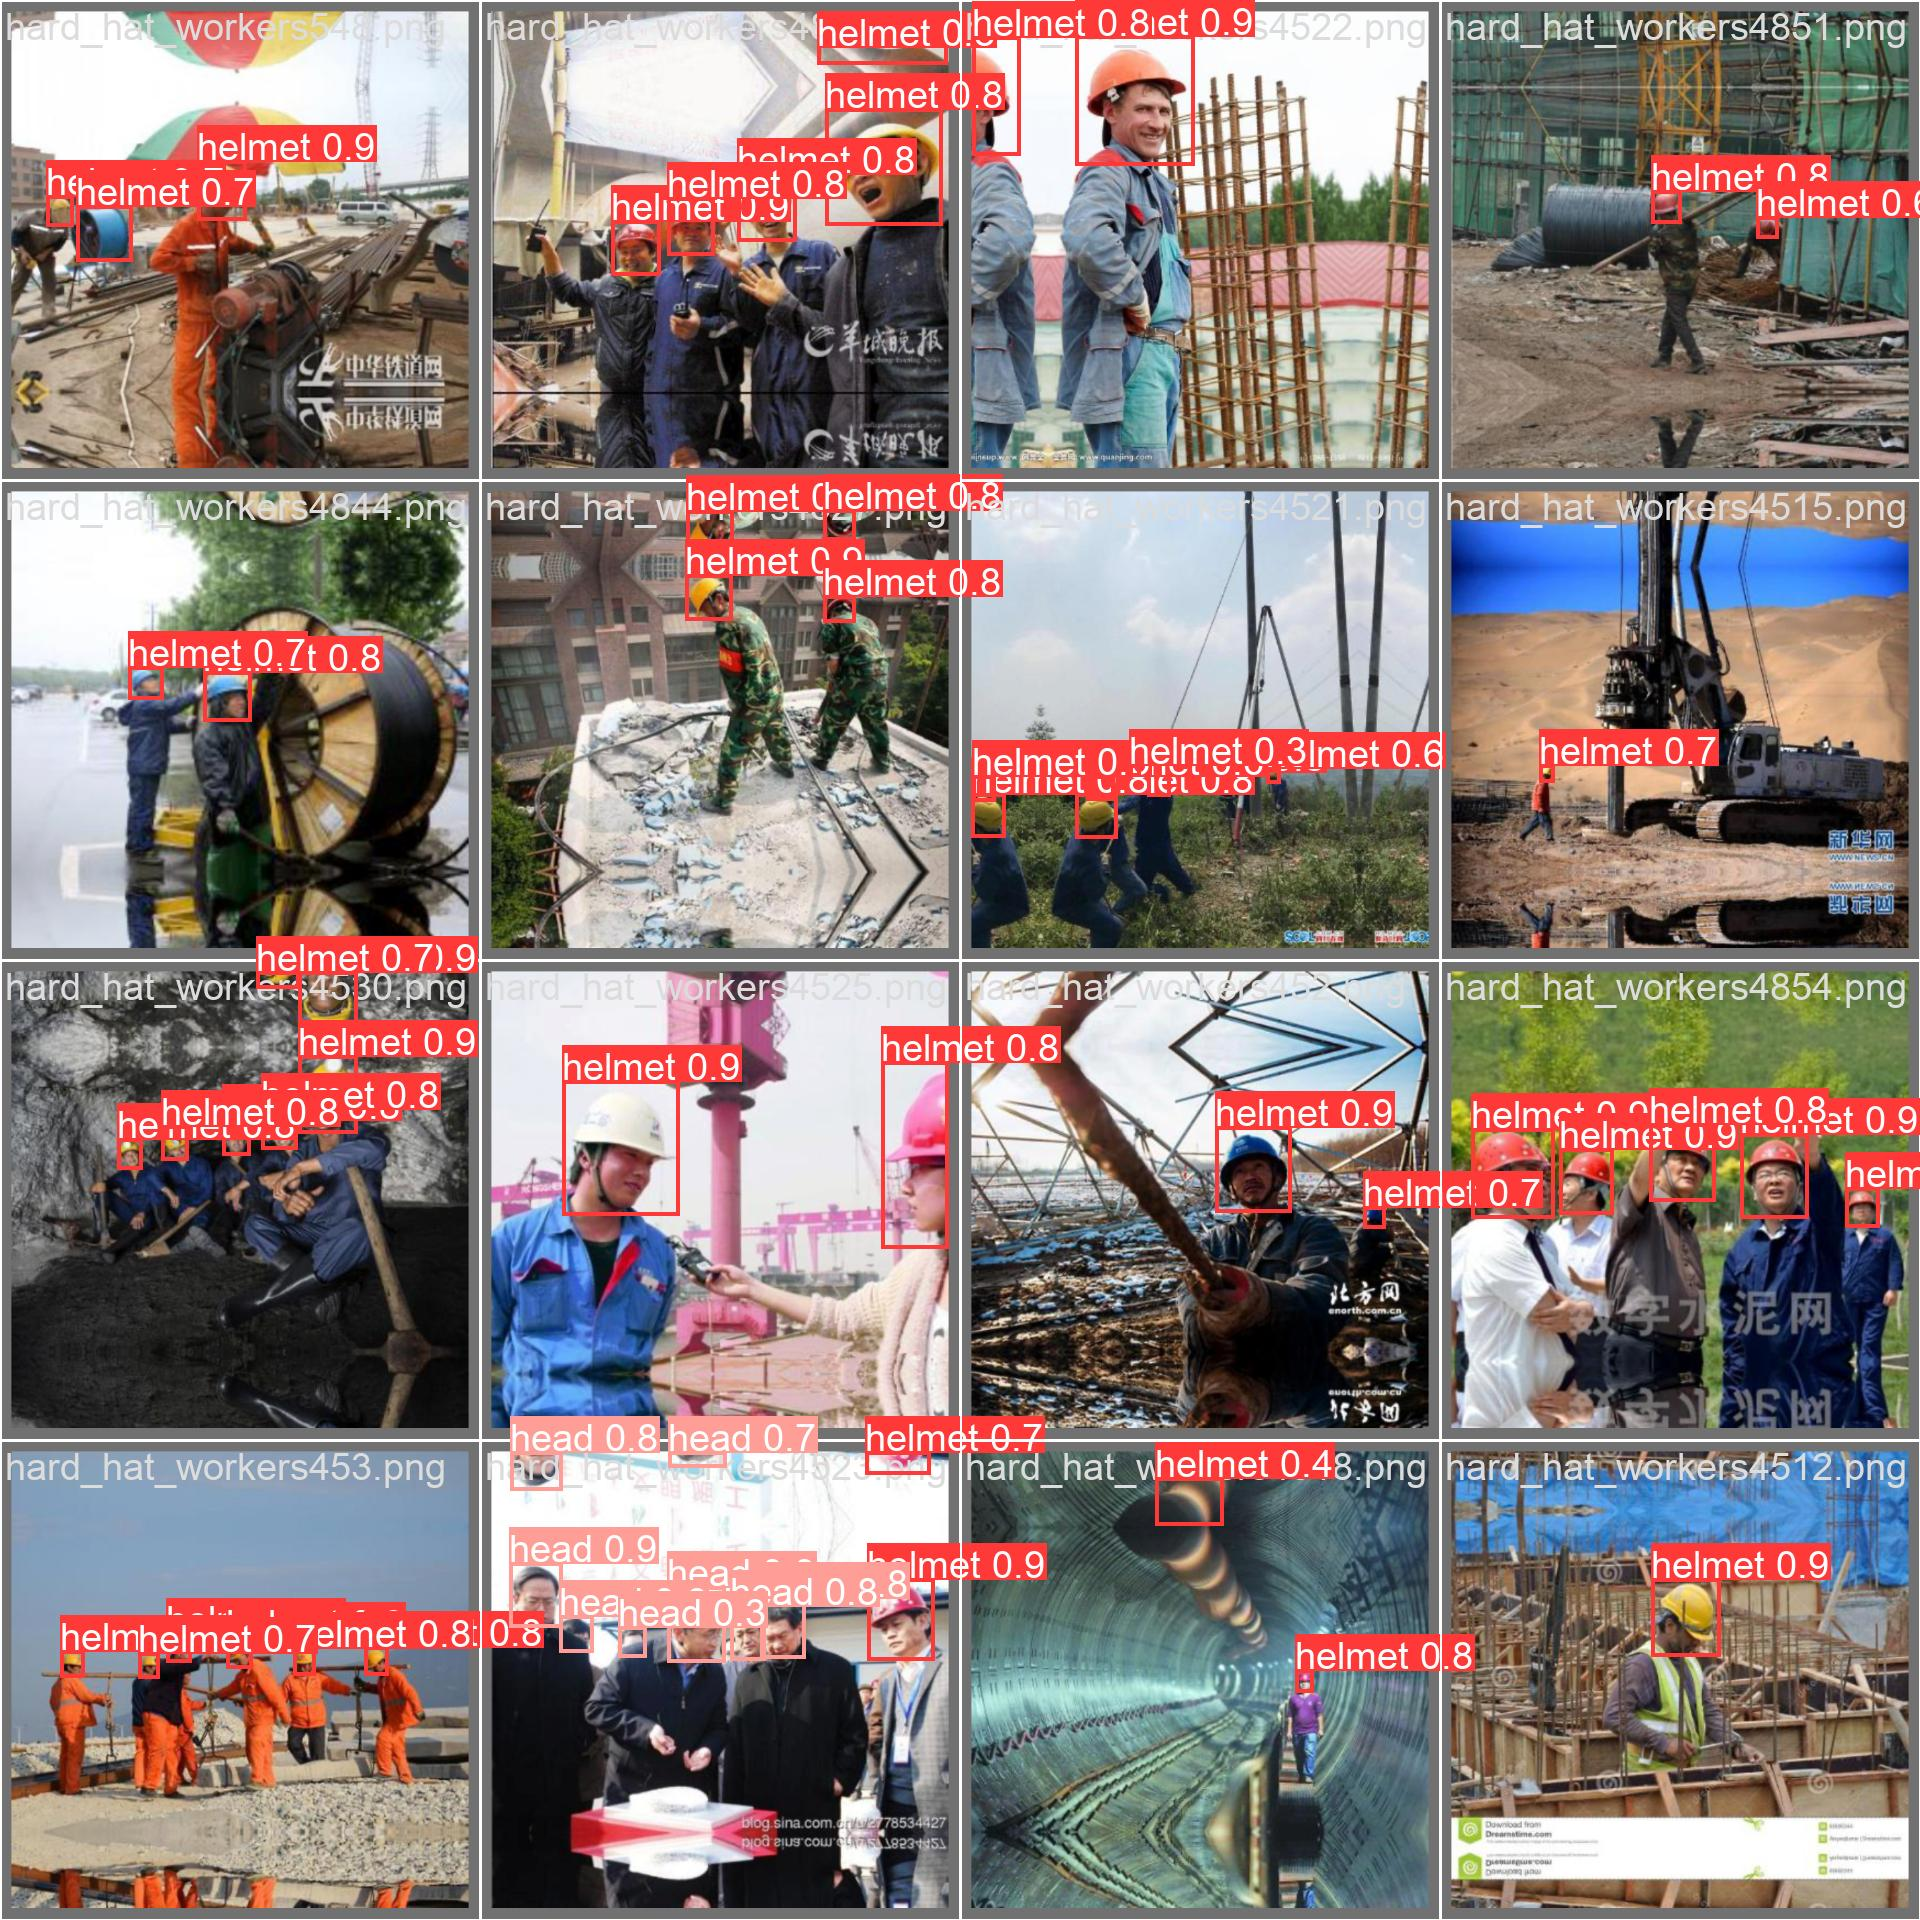

In [20]:
Image(filename=Path.cwd() / 'runs/detect/train16/val_batch0_pred.jpg', width=800)

In [3]:
results = model.val(data=dir / 'data.yaml', split='test')

Ultralytics YOLOv8.2.27  Python-3.12.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning D:\Repos\ProtectionDetection\datasets\helmet\test\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/32 [00:00<?, ?it/s]d:\Program Files (x86)\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


                   all        500       2610      0.957      0.597      0.638      0.423
                helmet        461       1947      0.947      0.923      0.968      0.646
                  head         91        573      0.925      0.869      0.926      0.617
                person         14         90          1          0     0.0186    0.00763
Speed: 0.4ms preprocess, 8.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\val


In [5]:
results = model.predict(source=Path.cwd() / 'datasets/helmet/test/images')


image 1/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers549.png: 640x640 1 helmet, 101.0ms
image 2/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers55.png: 640x640 7 helmets, 64.0ms
image 3/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers550.png: 640x640 2 helmets, 12.0ms
image 4/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers551.png: 640x640 1 helmet, 10.0ms
image 5/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers552.png: 640x640 8 helmets, 1 head, 10.0ms
image 6/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers553.png: 640x640 5 helmets, 11.0ms
image 7/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers554.png: 640x640 2 helmets, 10.0ms
image 8/500 d:\Repos\ProtectionDetection\datasets\helmet\test\images\hard_hat_workers555.png: 640x640 11 heads, 10.0ms
image 9/500 d:\Repos\ProtectionDet

In [85]:
time = 0
for i in range(0, len(results)):
    time += sum(results[i].speed.values())
i += 1
print("Average test FPS: %.2f" % (i / time * 1000))

Average test FPS: 68.37
